In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import keras
from keras import optimizers

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.externals import joblib

from sys import path
path.insert(0, '/content/drive/My Drive/Capstone/library')

from preprocessing import delete_face
from preprocessing import split_in_blocks
import normalization
import augmentation
from get_data import get_y
import SLT_model

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
# Useful Constants

n_steps = 50

augmentation_amount = 20

normalization_method = "wh"

without_face = True

X_train_path = "/content/drive/My Drive/Capstone/csv3/og/X_train_og.csv"
X_test_path = "/content/drive/My Drive/Capstone/csv3/og/X_test_og.csv"

Y_train_path = "/content/drive/My Drive/Capstone/csv3/og/Y_train_amount.csv"
Y_test_path = "/content/drive/My Drive/Capstone/csv3/og/Y_test_amount.csv"

In [0]:
X_train = pd.read_csv(X_train_path, header=None)
X_test = pd.read_csv(X_test_path, header=None)


col_list = ["file", "type", "file_name", "amount", "cumulative_sum"]
Y_train = pd.read_csv(Y_train_path, usecols=col_list)
Y_test = pd.read_csv(Y_test_path, usecols=col_list)

##Without face?

In [0]:
if without_face:
  X_train = delete_face(X_train.values.tolist())
  X_test = delete_face(X_test.values.tolist())

##Normalization

In [0]:
X_train, X_test = normalization.wh_method(X_train, X_test, without_face)

##Frame skip augmentation

In [7]:
Y = augmentation.get_augment_index(Y_train, augmentation_amount-1, n_steps)
X_np_train = augmentation.index_to_list(X_train.values.tolist(), Y, n_steps)

Y = augmentation.get_augment_index(Y_test, augmentation_amount-1, n_steps)
X_np_test = augmentation.index_to_list(X_test.values.tolist(), Y, n_steps)

90 th video : hit the limit!
220 th video : hit the limit!
237 th video : hit the limit!
245 th video : hit the limit!
250 th video : hit the limit!
293 th video : hit the limit!
298 th video : hit the limit!
325 th video : hit the limit!
329 th video : hit the limit!
419 th video : hit the limit!
454 th video : hit the limit!
464 th video : hit the limit!
493 th video : hit the limit!
705 th video : hit the limit!
709 th video : hit the limit!
729 th video : hit the limit!
753 th video : hit the limit!
816 th video : hit the limit!
853 th video : hit the limit!
859 th video : hit the limit!
882 th video : hit the limit!
982 th video : hit the limit!
1016 th video : hit the limit!
less than  50 !
94 43
94 baseline error! 21
these indexes will be added [8, 12, 21, 30, 33, 36, 38]
result :  [8298 8299 8300 8301 8302 8303 8304 8305 8306 8306 8307 8308 8309 8309
 8310 8311 8312 8313 8314 8315 8316 8317 8317 8318 8319 8320 8321 8322
 8323 8324 8325 8325 8326 8327 8327 8328 8329 8329 8330 83

In [0]:
# Load the networks inputs
X_pre_train = split_in_blocks(X_np_train, n_steps)
X_test = split_in_blocks(X_np_test, n_steps)

##y_train, y_val, y_test

In [0]:
y_pre_train, y_test = get_y(augmentation_amount)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_pre_train, y_pre_train, test_size = 0.3, random_state=64)

##Train it!

In [11]:
from keras.callbacks import EarlyStopping

# Input Data 
n_input = len(X_train[0][0])
n_hidden = 256 # Hidden layer num of features
n_classes = 35
learning_rate = 0.0007 #used if decaying_learning_rate set to False
decay_rate = 0.02 #the base of the exponential in the decay
lambda_loss_amount = 0.0015

training_epochs = 50
batch_size = 64

model = SLT_model.GRU_RNN(n_input, n_hidden, n_classes, lambda_loss_amount, batch_size, n_steps)

model.compile(
   optimizer=optimizers.Adam(lr=learning_rate, decay=decay_rate),
   metrics=['accuracy'],
   loss='categorical_crossentropy'
)

y_train_one_hot = keras.utils.to_categorical(y_train, 35)
y_val_one_hot = keras.utils.to_categorical(y_val, 35)
y_test_one_hot = keras.utils.to_categorical(y_test, 35)

train_size = X_train.shape[0] - X_train.shape[0] % batch_size
val_size = X_val.shape[0] - X_val.shape[0] % batch_size
test_size = X_test.shape[0] - X_test.shape[0] % batch_size

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, min_delta=0.005)

history = model.fit(
   X_train[:train_size,:,:], 
   y_train_one_hot[:train_size,:],
   epochs=training_epochs,
   batch_size=batch_size,
   validation_data=(X_val[:val_size,:,:], y_val_one_hot[:val_size,:]),
   callbacks=[es]
)

Train on 17600 samples, validate on 7552 samples
Epoch 1/50
17600/17600 [==============================] - 59s 3ms/step - loss: 2.7749 - accuracy: 0.2143 - val_loss: 2.2206 - val_accuracy: 0.3640
Epoch 2/50
17600/17600 [==============================] - 54s 3ms/step - loss: 1.8870 - accuracy: 0.4763 - val_loss: 1.6768 - val_accuracy: 0.5510
Epoch 3/50
17600/17600 [==============================] - 53s 3ms/step - loss: 1.4993 - accuracy: 0.6072 - val_loss: 1.3942 - val_accuracy: 0.6337
Epoch 4/50
17600/17600 [==============================] - 55s 3ms/step - loss: 1.2845 - accuracy: 0.6651 - val_loss: 1.2343 - val_accuracy: 0.6781
Epoch 5/50
17600/17600 [==============================] - 54s 3ms/step - loss: 1.1487 - accuracy: 0.7054 - val_loss: 1.1224 - val_accuracy: 0.7184
Epoch 6/50
17600/17600 [==============================] - 55s 3ms/step - loss: 1.0521 - accuracy: 0.7403 - val_loss: 1.0397 - val_accuracy: 0.7350
Epoch 7/50
17600/17600 [==============================] - 54s 3ms/ste

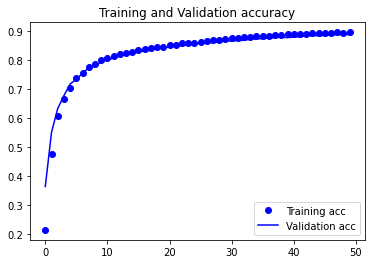

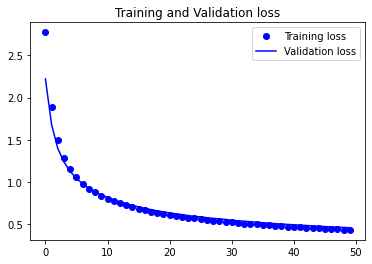

In [12]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label="Training acc")
plt.plot(epochs, val_acc, 'b', label="Validation acc")
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()

plt.show()

In [13]:
loss_and_metrics = model.evaluate(x=X_test[:test_size,:,:], y=y_test_one_hot[:test_size,:], batch_size=batch_size)

print(loss_and_metrics)

2752/2752 [==============================] - 2s 754us/step
[1.0413106238079626, 0.6504360437393188]


In [0]:
model_json = model.to_json()
with open("/content/drive/My Drive/Capstone/model/SLT-model-102-65.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("/content/drive/My Drive/Capstone/model/SLT-model-102-65.h5")